### Описание работы:
В рамках настоящей домашней работы я попытаюсь обучить модель на "сентимент" датасете, в котором размечены депрессия, тревожность и другие заболевания исходя из сообщений, которые люди запостили в твиттере

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


#### Датасет:

Загружаем датасет

In [2]:
df = pd.read_csv("Combined Data.csv")
df = df[['statement','status']].copy()

Анализ данных датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


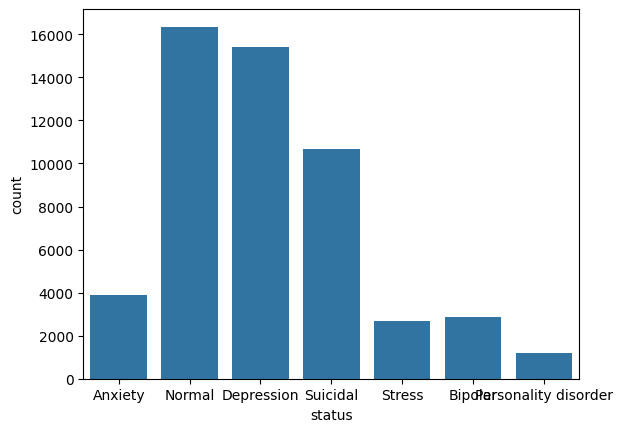

In [3]:
df.info()

sns.countplot(x='status', data=df)
plt.show()


Поскольку разброс между количеством классов большой я буду рассматривать только депрессию и норму.

#### Обработка датасета

In [20]:
# Удаляем заболевания
df_depr_norm = df[df['status'].isin(['Depression', 'Normal'])].reset_index(drop=True)
df_depr_norm['statement'] = df_depr_norm['statement'].astype(str)
texts = df_depr_norm['statement'].tolist()  
df_depr_norm

,statement,status
0,"Gr gr dreaming of ex crush to be my game, God",Normal
1,wkwkwk what a joke,Normal
2,Leaves are also standby in front of the PC ......,Normal
3,Thank God even though it's just a ride through,Normal
4,wedding teaser concept using the song day6 - o...,Normal
...,...,...
31750,"solutions So, when I have my real bad downs th...",Depression
31751,I’m pretty sure I’m depressed.. Ive been feeli...,Depression
31752,I can’t be bothered anymore. I’m a 22 year old...,Depression
31753,Depression feels like you’re drowning and ther...,Depression


In [21]:
# Создаем токенизатор и обучаем на текстах
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Добиваем последовательности до одной длинны
padded_sequences = pad_sequences(sequences, padding='post')

Создадим финальный датафрейм с числовыми значениям

In [ ]:
data = pd.DataFrame()
data['statements'] = list(padded_sequences)  
data['status'] = df_depr_norm['status']
# Приводим категориальные данные в числовые
data['status'] = status = LabelEncoder().fit_transform(df_depr_norm['status'])
data # 1 - Normal, 0 - Depression

,statements,status
0,"[10163, 10163, 2442, 8, 622, 1735, 2, 24, 6, 6...",1
1,"[4593, 36, 5, 954, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[1845, 48, 136, 10164, 15, 738, 8, 4, 1903, 38...",1
3,"[415, 406, 45, 232, 259, 19, 5, 1607, 158, 0, ...",1
4,"[2129, 5562, 2847, 858, 4, 1363, 15863, 80, 98...",1
...,...,...
31750,"[3249, 21, 49, 1, 12, 6, 318, 127, 2971, 66, 1...",0
31751,"[295, 285, 245, 295, 140, 1042, 41, 103, 20, 1...",0
31752,"[1, 799, 24, 1702, 99, 295, 5, 1246, 111, 247,...",0
31753,"[67, 231, 23, 3592, 1758, 3, 66, 10, 47, 112, ...",0


#### Переходим к обучению 

In [22]:
# Делим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, status, test_size=0.2, shuffle=False)
print(type(X_train))  
print(X_train.shape)  
print(type(y_train))  
print(y_train.shape)  

<class 'numpy.ndarray'>
(25404, 4239)
<class 'numpy.ndarray'>
(25404,)


In [23]:
print(len(tokenizer.word_index))

46262


In [27]:
model = Sequential([
    # Слой векторизации текста
    layers.Embedding(input_dim=46263, output_dim=100,mask_zero=True),
    
    # Первый сверточный слой
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # Второй сверточный слой
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # Преобразование в одномерный вектор
    layers.Flatten(),

    # Полносвязный слой
    layers.Dense(128, activation='relu'),
    
    # Выходной слой с активацией softmax
    layers.Dense(1, activation='sigmoid')  # 1 выход, так как задача бинарной классификации (депрессия/не депрессия)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Оцениваем модель
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")


# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5


C:\Users\Владимир\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  4/794 ━━━━━━━━━━━━━━━━━━━━ 2:05 159ms/step - accuracy: 0.5586 - loss: 0.9853

KeyboardInterrupt: 